# Accuracy Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

In [2]:
sim_path = '../../results/synth_classification_v3/25-08-2023-18:23'

In [3]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

runs_dirs = get_immediate_subdirectories(sim_path)
runs_dirs.sort()

In [4]:
# runs_dirs = ['10']

In [5]:
pre_AL_accuracy = {}
clairvoyant_final_accuracy = {}
concept_list_dict = {}
test_set = {}
weights = {}
metadata = {}

ed_sampling_accuracy = {}
entropy_sampling_accuracy = {}
random_sampling_accuracy = {}
clairvoyant_accuracy = {}

weighted_sampling_scores = {}

ed_selected_samples = {}
es_selected_samples = {}
rs_selected_samples = {}

ed_relabeled_samples = {}
es_relabeled_samples = {}
rs_relabeled_samples = {}

STRATEGIES = [
    "EntropyDiversitySampling",
    "EntropySampling",
    "RandomSamplingV3",
    "clairvoyant"
]

for run in runs_dirs:

    with open(sim_path + '/'+ run +'/metadata.json', 'r') as f:
        metadata[run] = json.load(f)

    run_path = sim_path + '/' + run + '/'

    concept_list_dict[run] = []

    test_set[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'test_set.csv',
        dtype='str'
    ).astype('float64')

    # weights[run] = pd.read_csv(
    #     filepath_or_buffer=run_path + 'weights.csv',
    #     dtype='str'
    # ).astype('float64')

    for n in range(metadata[run]['n_concepts']):

        # noinspection PyTypeChecker
        concept_list_dict[run].append(pd.read_csv(
            filepath_or_buffer=run_path + 'concept_' + str(n) + '.csv',
            dtype='str'
        ).astype('float64'))

    pre_AL_accuracy[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'pre_AL_accuracy.csv',
        dtype='str',
        header=None
    ).astype('float64').iloc[0, 0]

    clairvoyant_final_accuracy[run] = pd.read_csv(
        filepath_or_buffer=run_path + 'clairvoyant_final_accuracy.csv',
        dtype='str',
        header=None
    ).astype('float64').iloc[0, 0]

    entropy_sampling_accuracy[run] = {}
    random_sampling_accuracy[run] = {}
    clairvoyant_accuracy[run] = {}
    ed_sampling_accuracy[run] = {}
    
    weighted_sampling_scores[run] = {}

    for strategy in STRATEGIES:

        strategy_path = run_path + strategy

        if strategy == 'EntropySampling':

            es_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')
            
            # ws_relabeled_samples[run] = pd.read_csv(
            #     filepath_or_buffer=strategy_path + '/' + 'relabeled_samples.csv',
            #     dtype='str'
            # ).astype('float64')

        elif strategy == 'RandomSamplingV3':
            rs_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')
            
            # rs_relabeled_samples[run] = pd.read_csv(
            #     filepath_or_buffer=strategy_path + '/' + 'relabeled_samples.csv',
            #     dtype='str'
            # ).astype('float64')
        
        elif strategy == 'EntropyDiversitySampling':
            ed_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
            ).astype('float64')
            
            # ed_relabeled_samples[run] = pd.read_csv(
            #     filepath_or_buffer=strategy_path + '/' + 'relabeled_samples.csv',
            #     dtype='str'
            # ).astype('float64')

        for n in range(metadata[run]['n_samples']):
            n_sample = n + 1

            sample_path = strategy_path + '/' + str(n_sample) + '_samples.csv'

            if strategy == "EntropySampling":
                entropy_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]
                
                # score_path = strategy_path + '/' + str(n_sample) + '_score.csv'
                #     
                # weighted_sampling_scores[run][n_sample] = pd.read_csv(
                #     filepath_or_buffer=score_path,
                #     dtype='str',
                #     index_col=0,
                #     header=None
                # ).astype('float64')

            elif strategy == "RandomSamplingV3":
                random_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

            elif strategy == "clairvoyant":
                clairvoyant_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]
            
            elif strategy == "EntropyDiversitySampling":
                ed_sampling_accuracy[run][n_sample] = pd.read_csv(
                    filepath_or_buffer=sample_path,
                    dtype='str',
                    header=None
                ).astype('float64').iloc[0, 0]

In [6]:
import matplotlib.colors as mcolors

color_cycle = mcolors.TABLEAU_COLORS  # You can choose any color set here
color_names = list(color_cycle.keys())

n_classes = metadata[runs_dirs[0]]['n_classes']

color_list = [color_cycle[color_names[i]] for i in range(n_classes)]

### Plot Concepts

In [7]:
%%script false --no-raise-error

for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        if index == len(concept_list) - 1:
            test_classes_groups = test_set[run].groupby('y_0')

            for test_index, ((test_label, test_group), (label, group))  in enumerate(zip(test_classes_groups, classes_groups)):
                ax.scatter(test_group['X_0'], test_group['X_1'], color=color_list[int(label)], alpha=0.2
                )
                ax.scatter(group['X_0'], group['X_1'], label=label, color=color_list[int(label)])
        else:
            for i, (label, group) in enumerate(classes_groups):
                ax.scatter(group['X_0'], group['X_1'], label=label, color=color_list[int(label)])



        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()

### Computing mean and std accuracy

In [8]:
mean_pre_AL_accuracy = np.mean(
    a=list(pre_AL_accuracy.values()),
    axis=0
)
mean_pre_AL_accuracy

0.6797916666666666

In [9]:
mean_clairvoyant_accuracy = np.mean(
    a=list(clairvoyant_final_accuracy.values()),
    axis=0
)
mean_clairvoyant_accuracy

0.7902083333333333

In [10]:
ed_accuracy = {}
for run in ed_sampling_accuracy.keys():
    ed_accuracy[run] = []
    for key in ed_sampling_accuracy[run].keys():
        ed_accuracy[run].append(ed_sampling_accuracy[run][key])

In [11]:
es_accuracy = {}
for run in entropy_sampling_accuracy.keys():
    es_accuracy[run] = []
    for key in entropy_sampling_accuracy[run].keys():
        es_accuracy[run].append(entropy_sampling_accuracy[run][key])

In [12]:
rs_accuracy = {}
for run in random_sampling_accuracy.keys():
    rs_accuracy[run] = []
    for key in random_sampling_accuracy[run].keys():
        rs_accuracy[run].append(random_sampling_accuracy[run][key])

In [13]:
cl_accuracy = {}
for run in clairvoyant_accuracy.keys():
    cl_accuracy[run] = []
    for key in clairvoyant_accuracy[run].keys():
        cl_accuracy[run].append(clairvoyant_accuracy[run][key])

In [14]:
mean_ed_accuracy = np.mean(a=list(ed_accuracy.values()), axis=0)
mean_es_accuracy = np.mean(a=list(es_accuracy.values()), axis=0)
mean_rs_accuracy = np.mean(a=list(rs_accuracy.values()), axis=0)
mean_cl_accuracy = np.mean(a=list(cl_accuracy.values()), axis=0)

In [15]:
std_ed_accuracy = np.std(a=list(ed_accuracy.values()), axis=0) / np.sqrt(metadata[runs_dirs[0]]['test_set_size'])
std_es_accuracy = np.std(a=list(es_accuracy.values()), axis=0) / np.sqrt(metadata[runs_dirs[0]]['test_set_size'])
std_rs_accuracy = np.std(a=list(rs_accuracy.values()), axis=0) / np.sqrt(metadata[runs_dirs[0]]['test_set_size'])
std_cl_accuracy = np.std(a=list(cl_accuracy.values()), axis=0) / np.sqrt(metadata[runs_dirs[0]]['test_set_size'])

In [16]:
len(mean_es_accuracy)/2

100.0

### Plot results

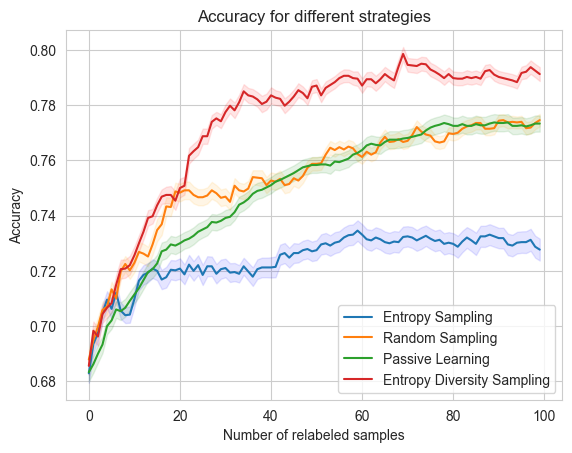

In [17]:
# create a new figure and axis object
fig, ax = plt.subplots()


# plot the accuracy values for each model as a line
ax.plot(range(len(mean_es_accuracy[:100])), mean_es_accuracy[:100], label='Entropy Sampling')
ax.plot(range(len(mean_rs_accuracy[:100])), mean_rs_accuracy[:100], label='Random Sampling')
ax.plot(range(len(mean_cl_accuracy[:100])), mean_cl_accuracy[:100], label='Passive Learning')
ax.plot(range(len(mean_ed_accuracy[:100])), mean_ed_accuracy[:100], label='Entropy Diversity Sampling')
ax.fill_between(range(len(mean_ed_accuracy[:100])), mean_ed_accuracy[:100] - std_ed_accuracy[:100], mean_ed_accuracy[:100] + std_ed_accuracy[:100], color='red', alpha=0.1)
ax.fill_between(range(len(mean_es_accuracy[:100])), mean_es_accuracy[:100] - std_es_accuracy[:100], mean_es_accuracy[:100] + std_es_accuracy[:100], color='blue', alpha=0.1)
ax.fill_between(range(len(mean_rs_accuracy[:100])), mean_rs_accuracy[:100] - std_rs_accuracy[:100], mean_rs_accuracy[:100] + std_rs_accuracy[:100], color='orange', alpha=0.1)
ax.fill_between(range(len(mean_cl_accuracy[:100])), mean_cl_accuracy[:100] - std_cl_accuracy[:100], mean_cl_accuracy[:100] + std_cl_accuracy[:100], color='green', alpha=0.1)
# plt.axhline(y=mean_pre_AL_accuracy, color='r', linestyle='-', label='Pre AL')
# plt.axhline(y=mean_clairvoyant_accuracy, color='y', linestyle='-', label='Clairvoyant Final')

# add a legend to the plot
ax.legend()

# set the x-axis label
ax.set_xlabel('Number of relabeled samples')

# set the y-axis label
ax.set_ylabel('Accuracy')

# set the title of the plot
ax.set_title('Accuracy for different strategies')

# display the plot

plt.show()

### Plot Selected Samples

In [18]:
pd.set_option('display.max_rows', None)

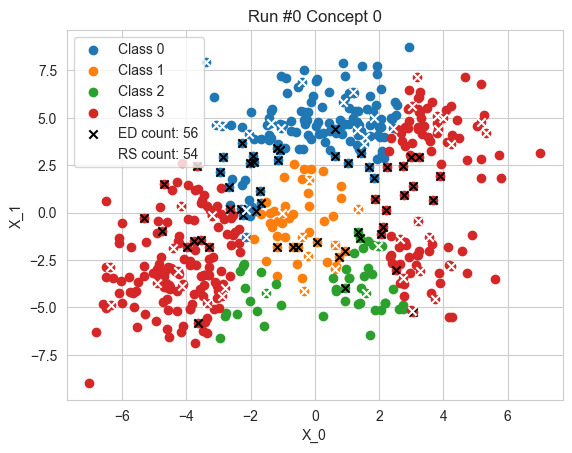

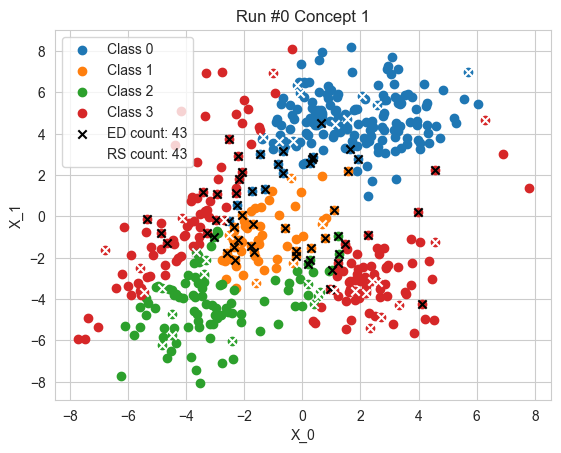

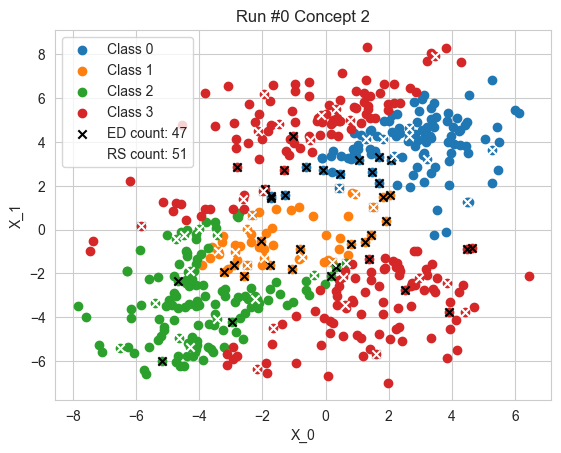

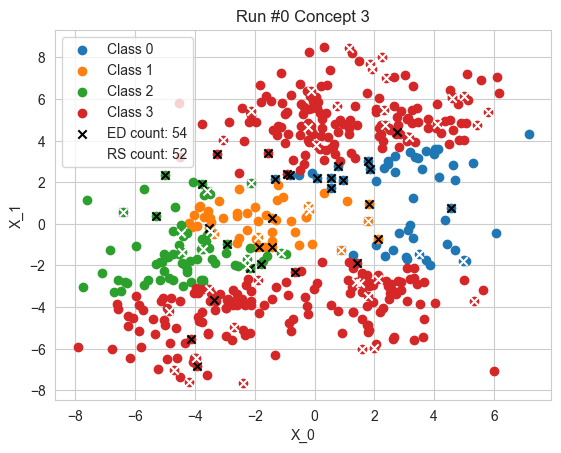

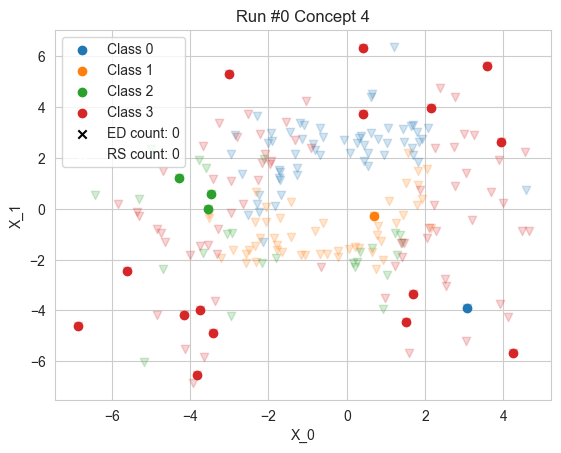

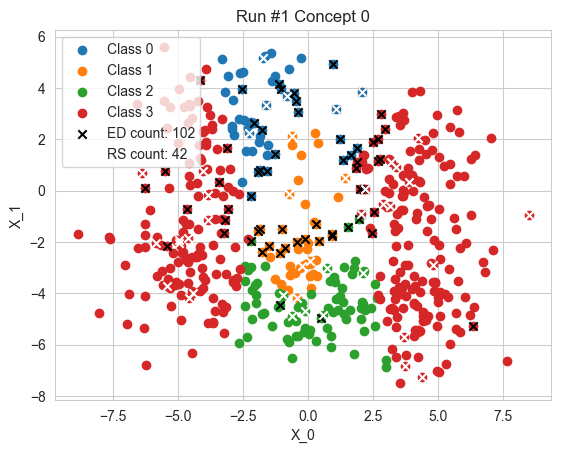

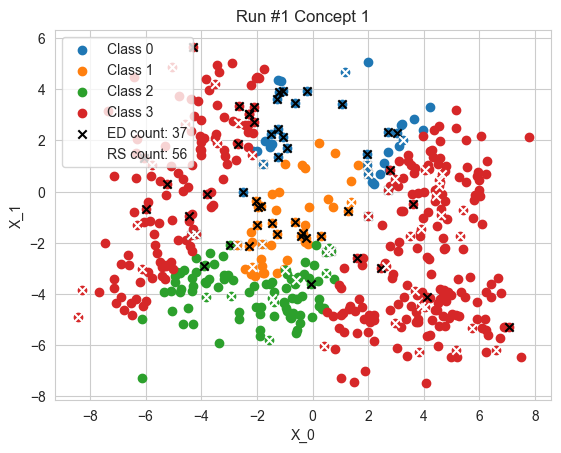

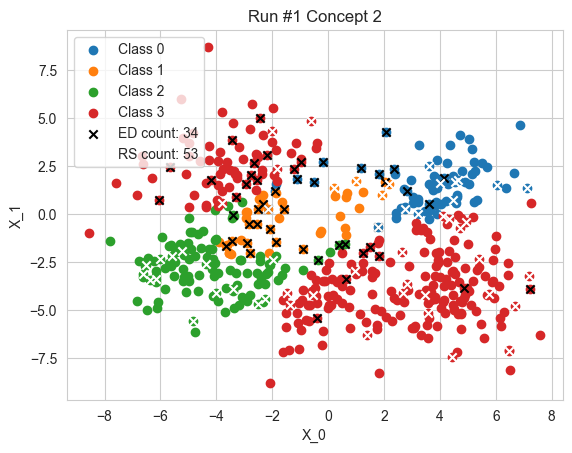

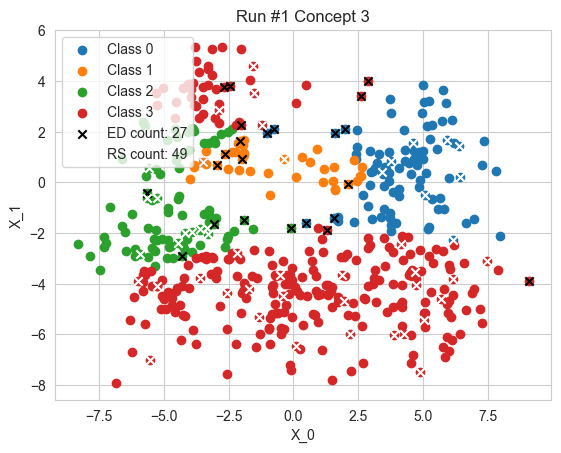

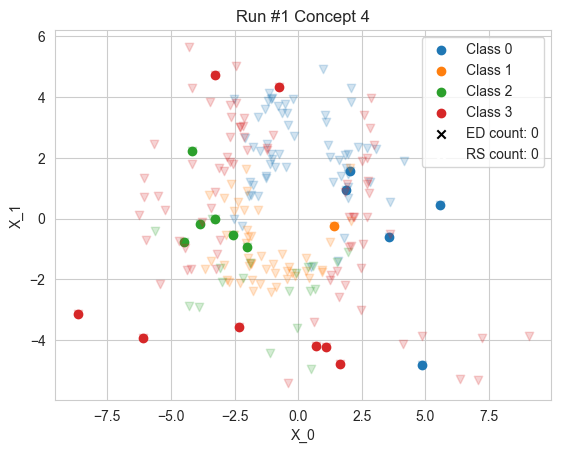

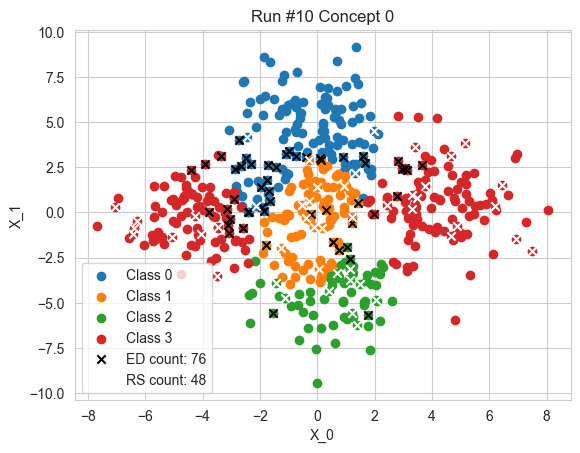

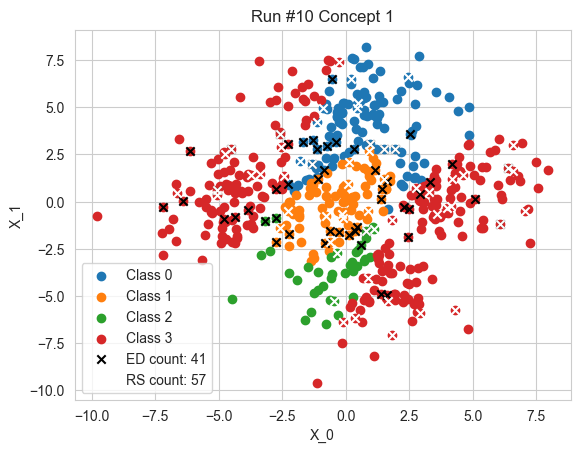

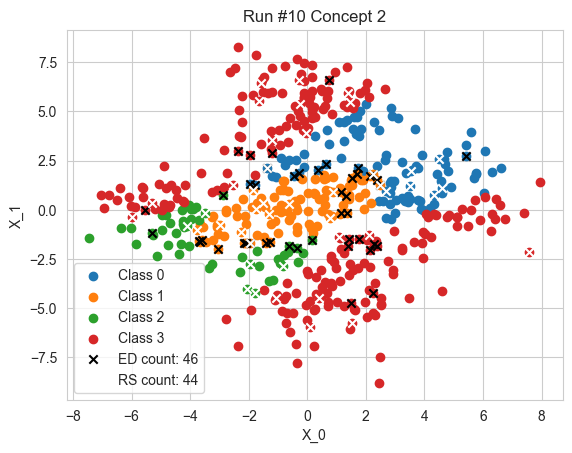

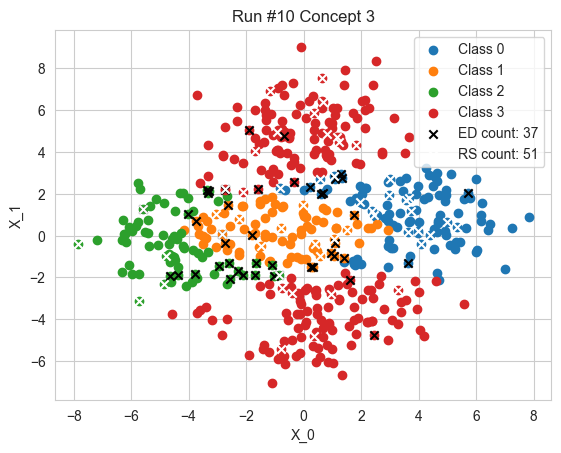

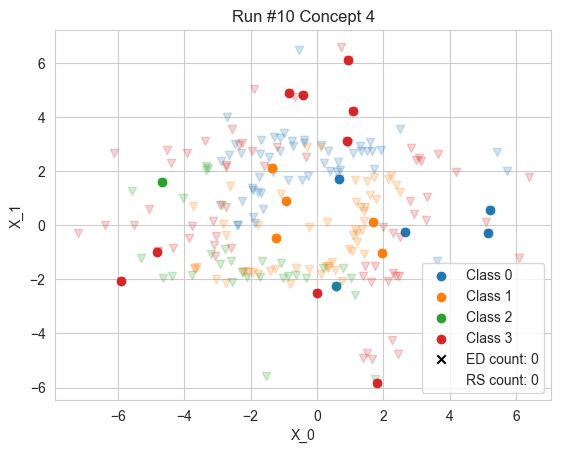

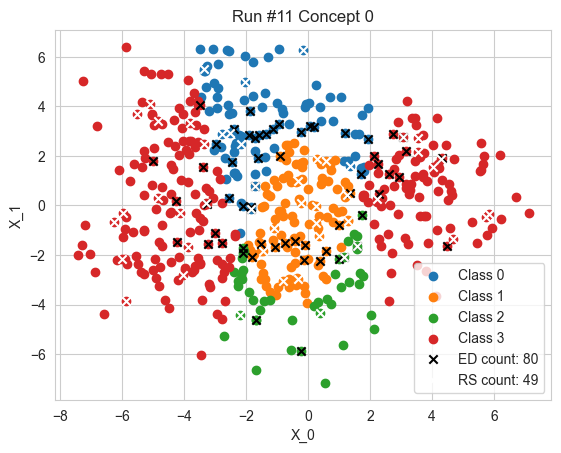

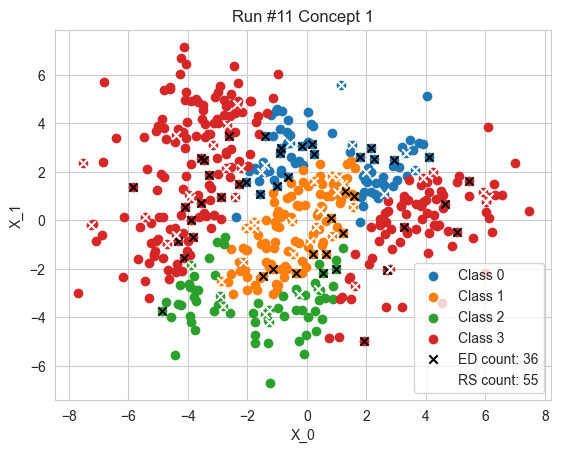

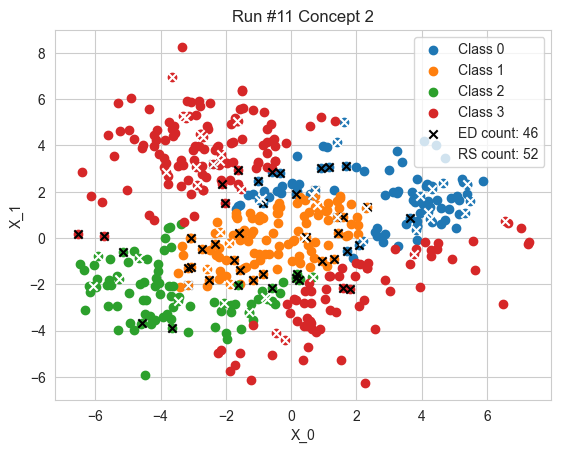

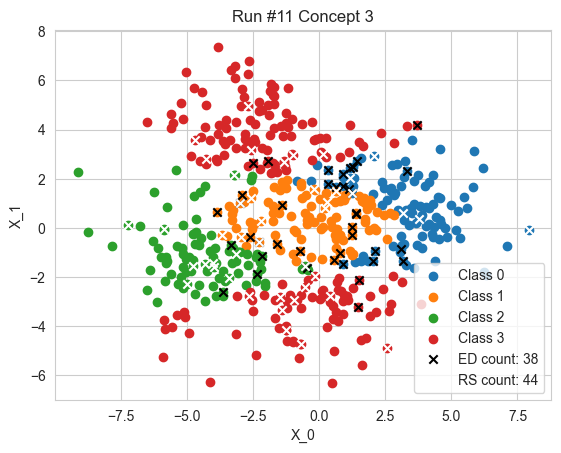

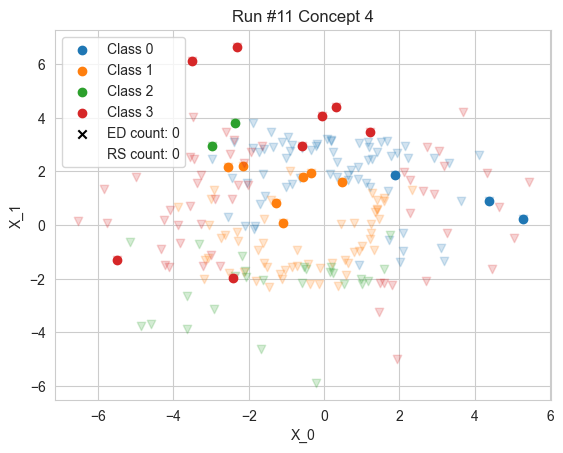

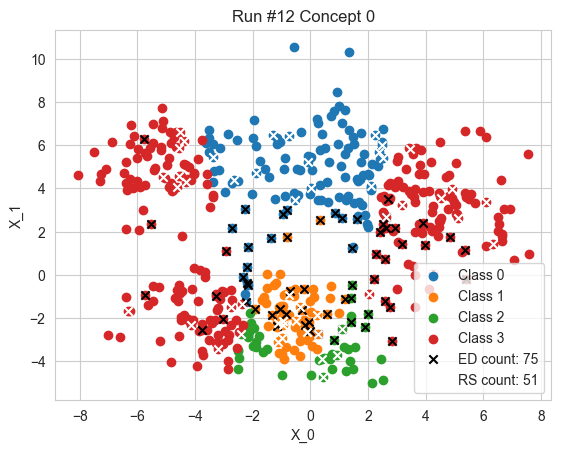

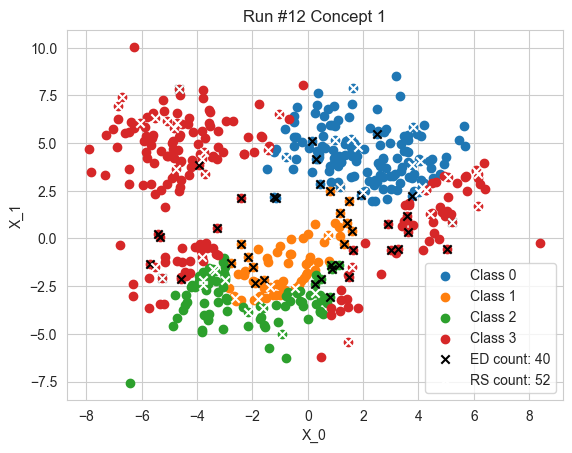

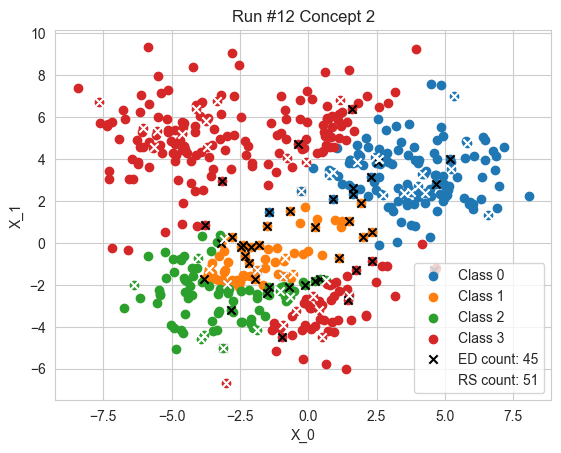

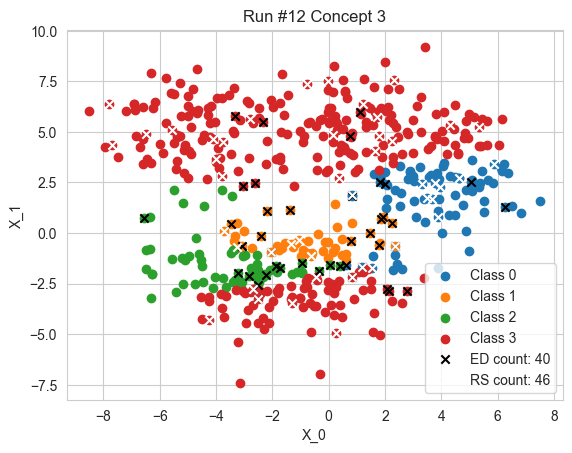

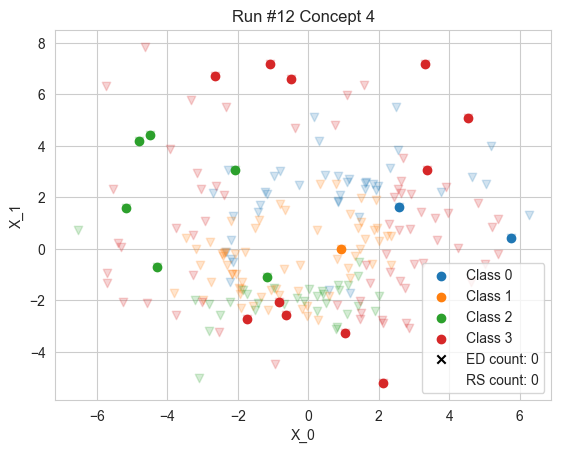

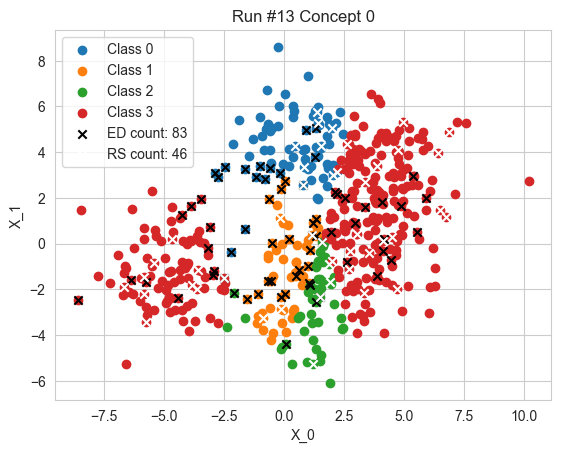

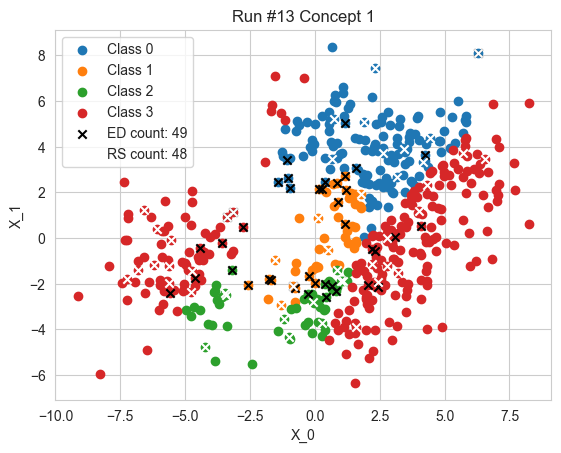

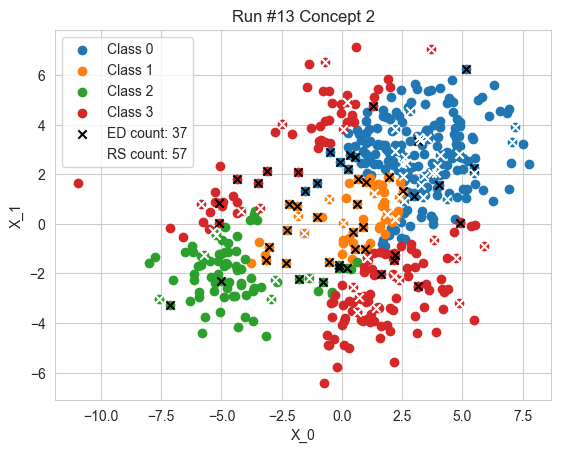

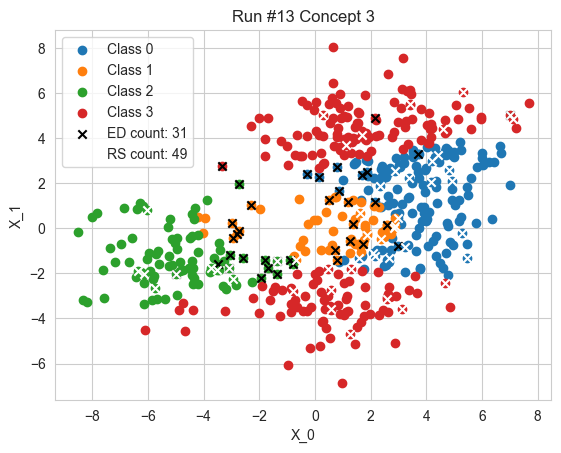

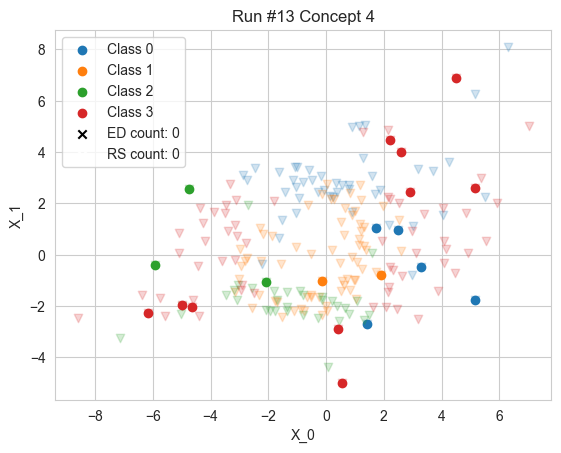

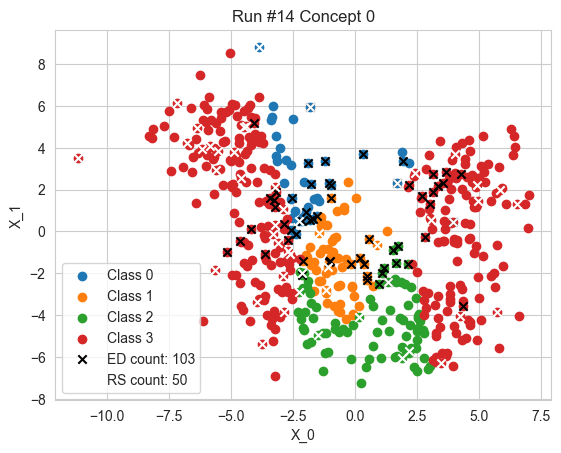

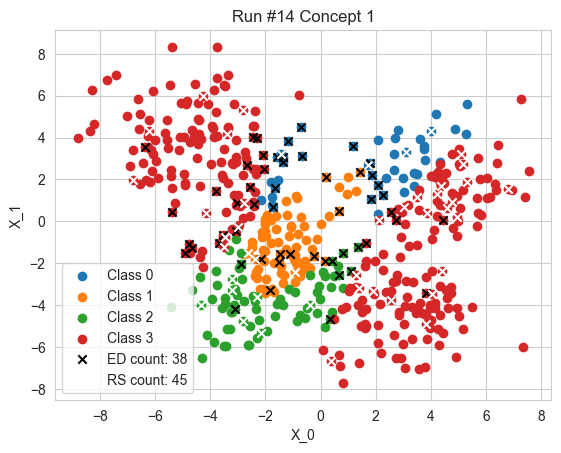

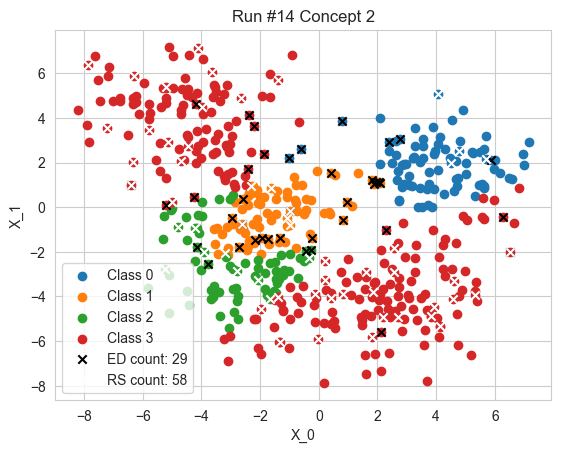

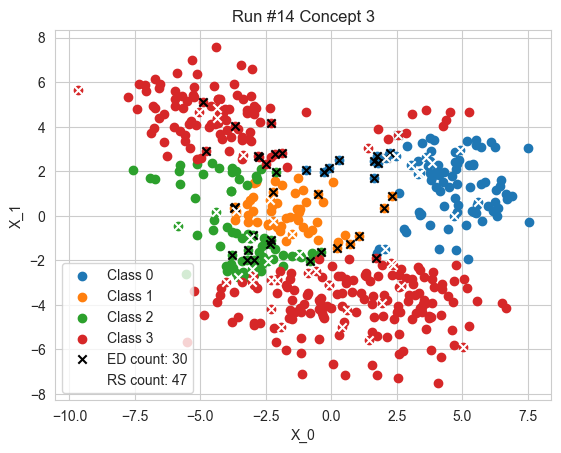

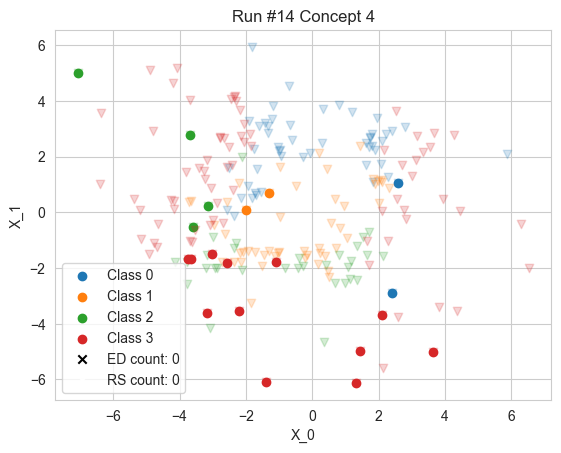

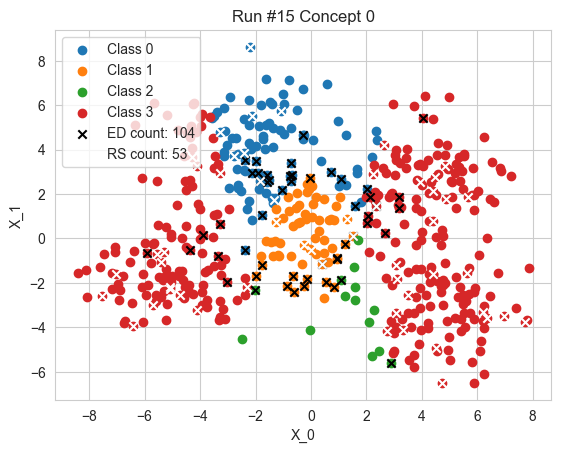

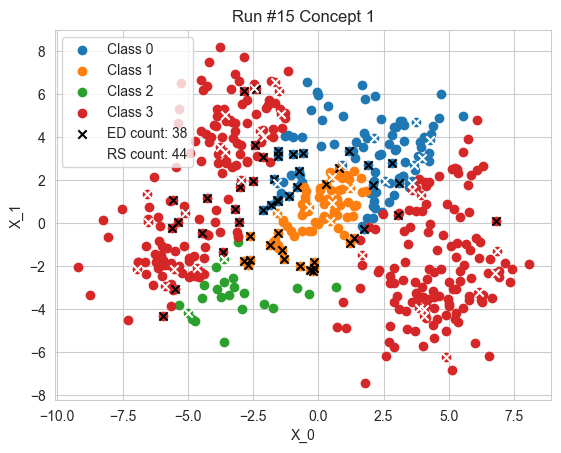

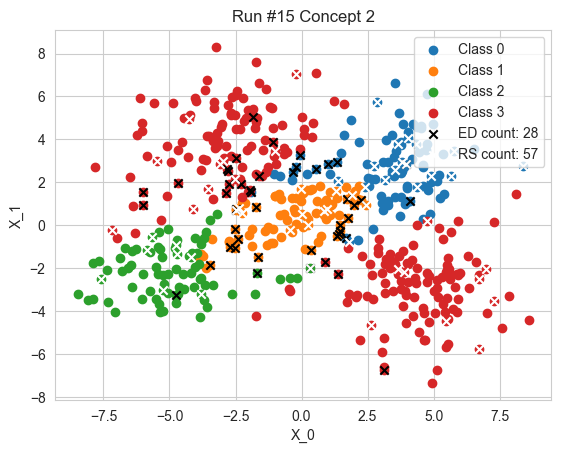

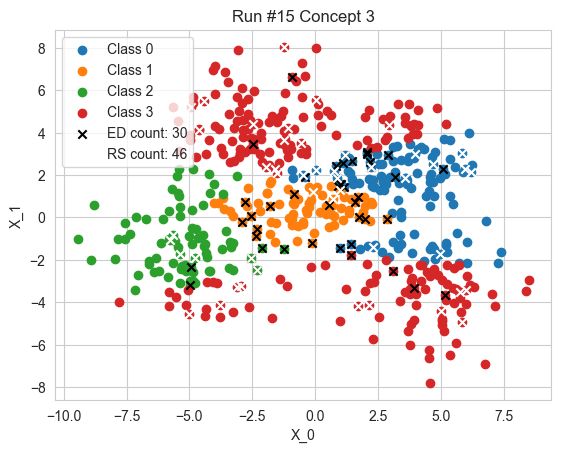

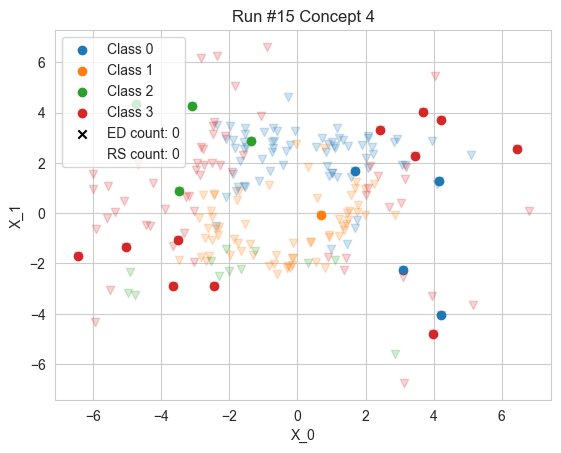

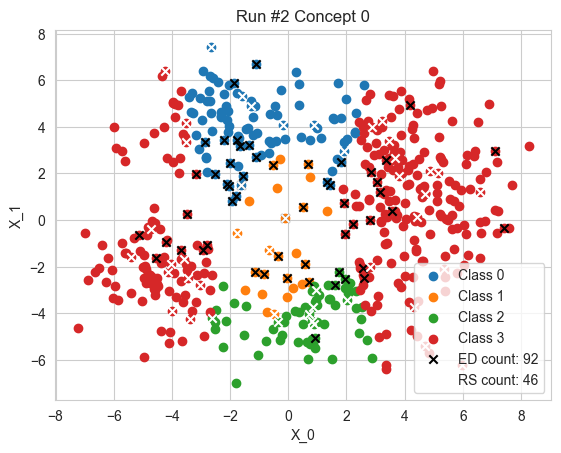

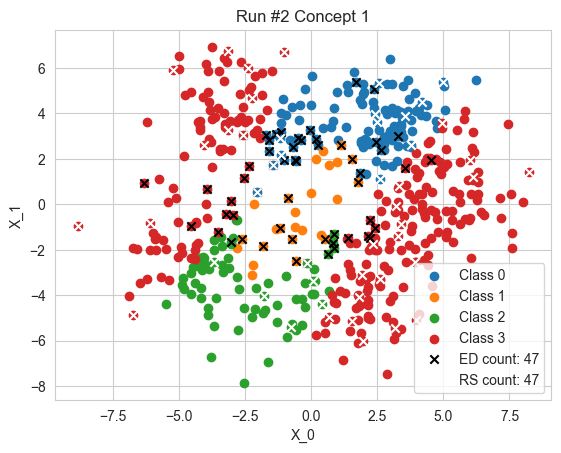

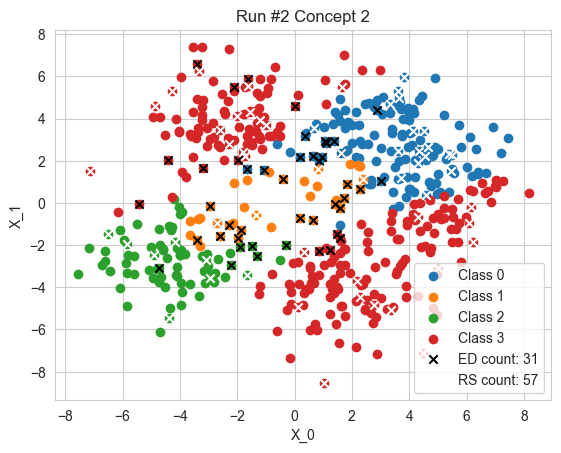

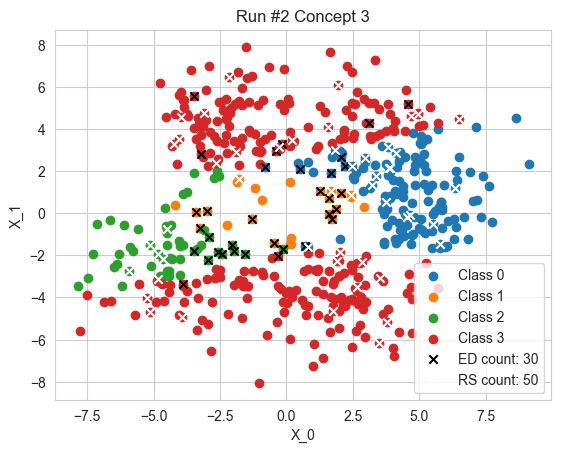

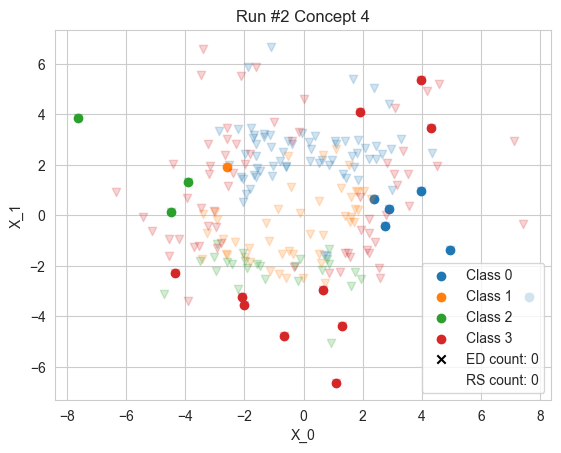

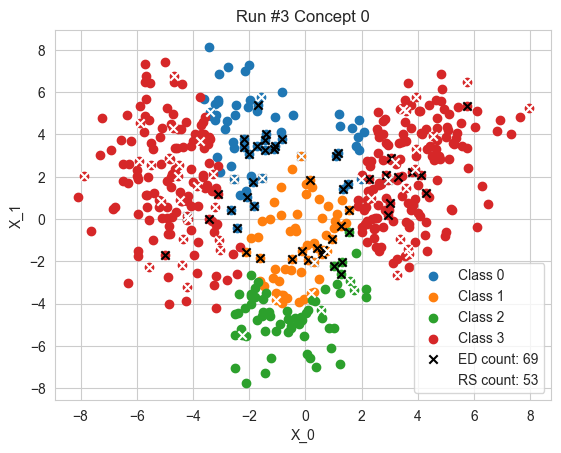

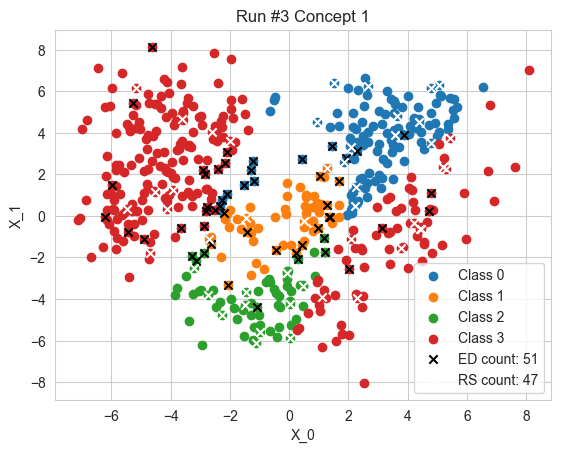

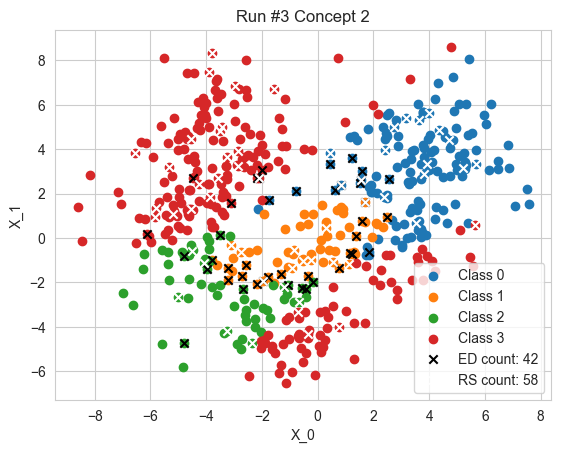

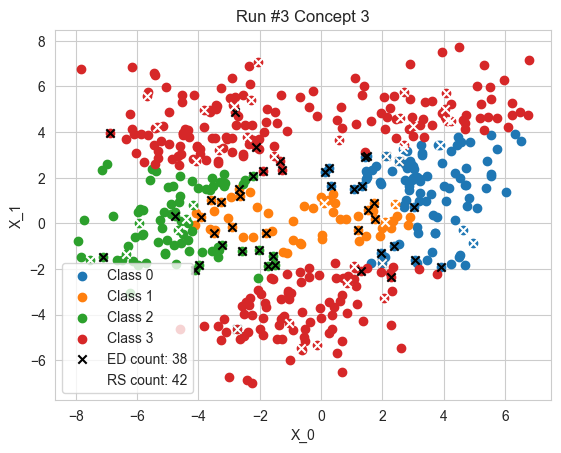

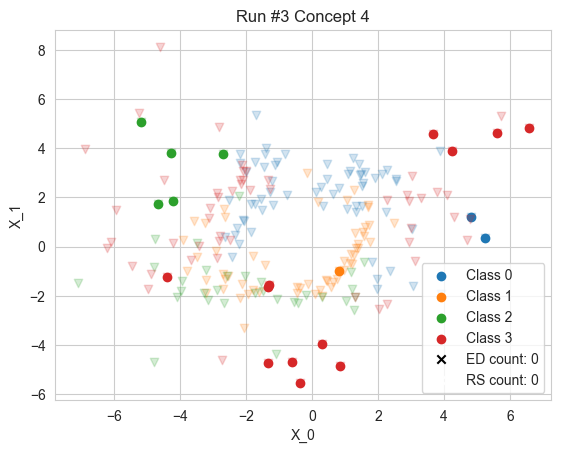

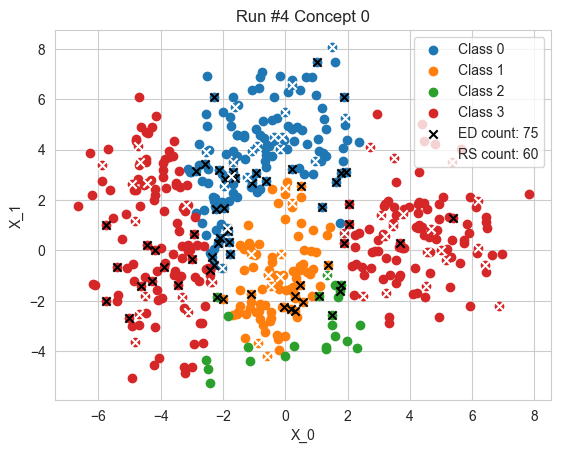

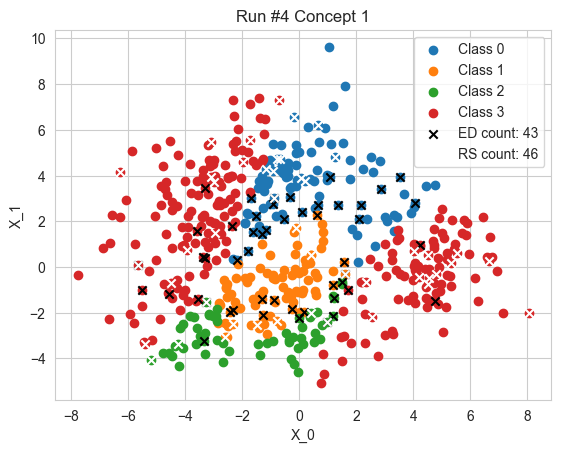

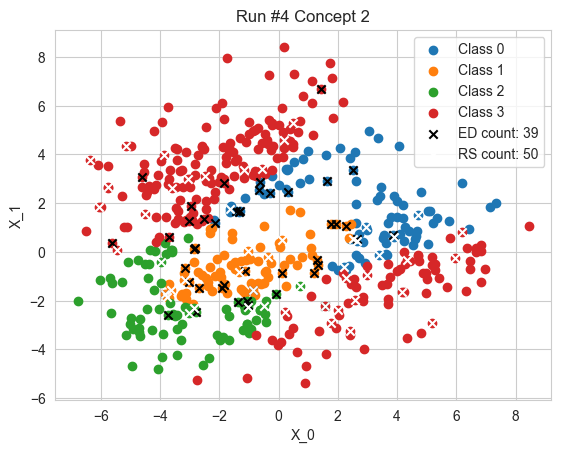

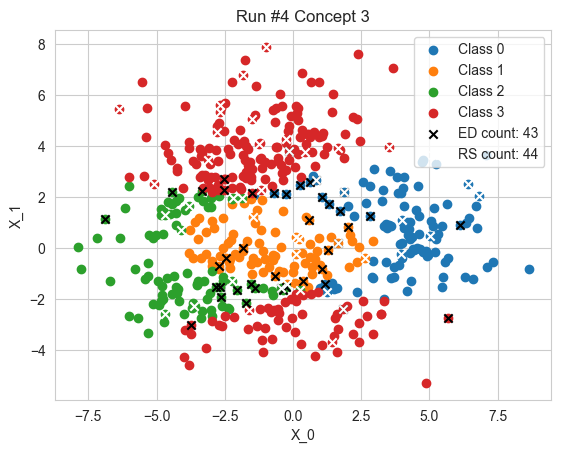

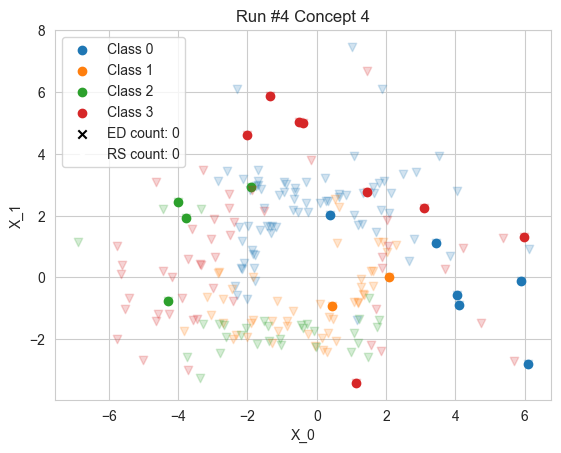

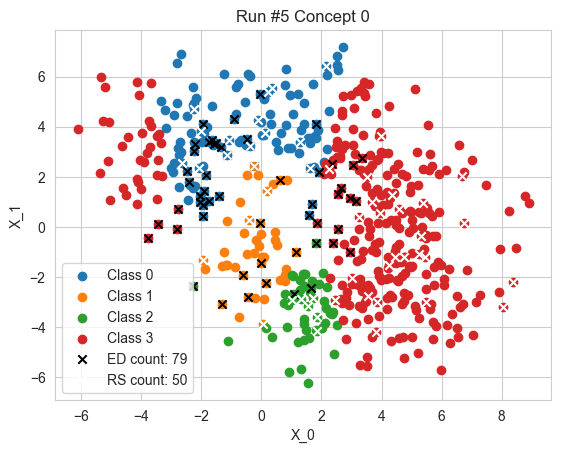

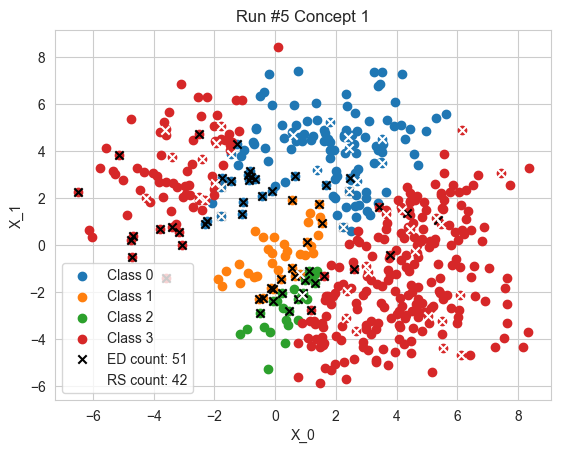

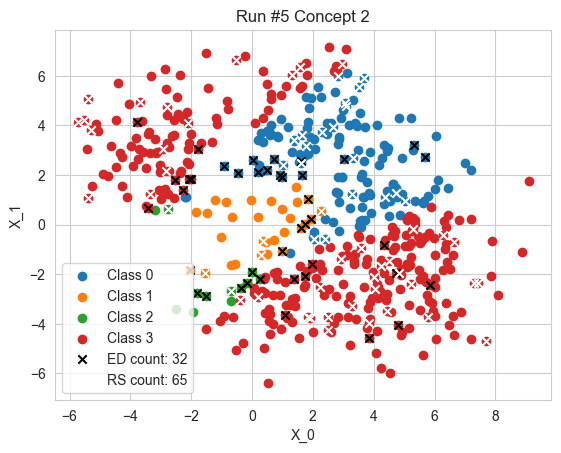

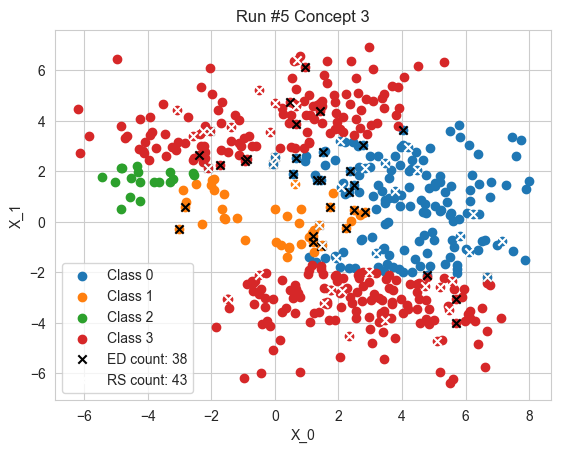

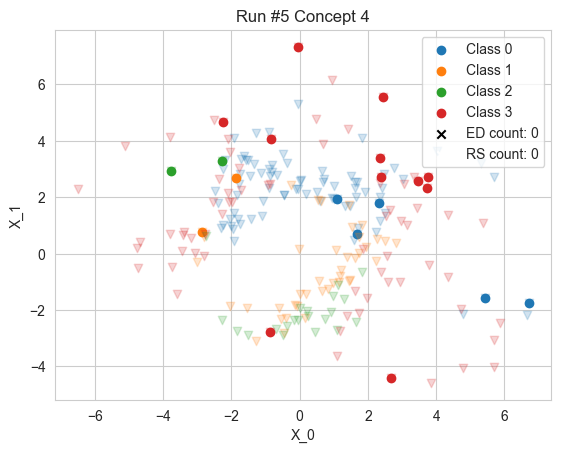

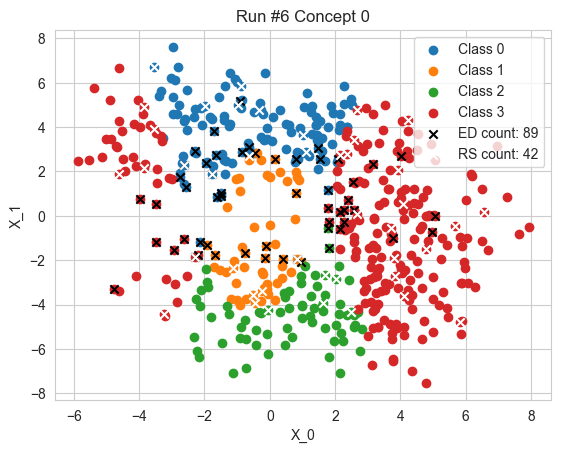

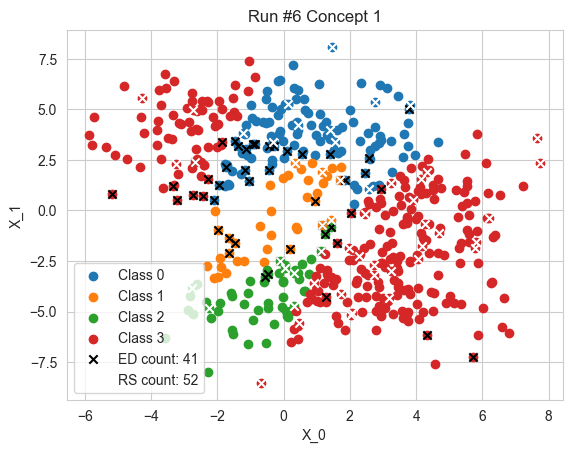

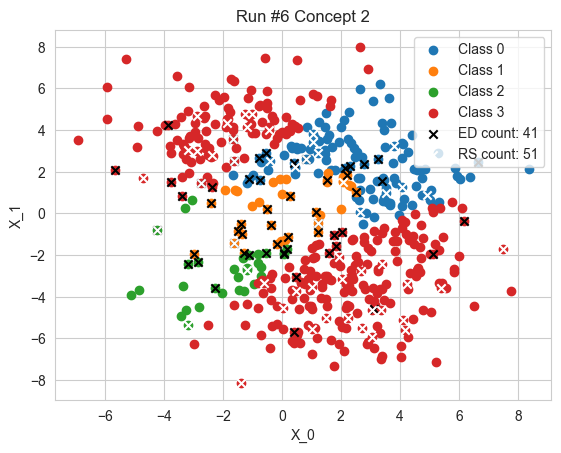

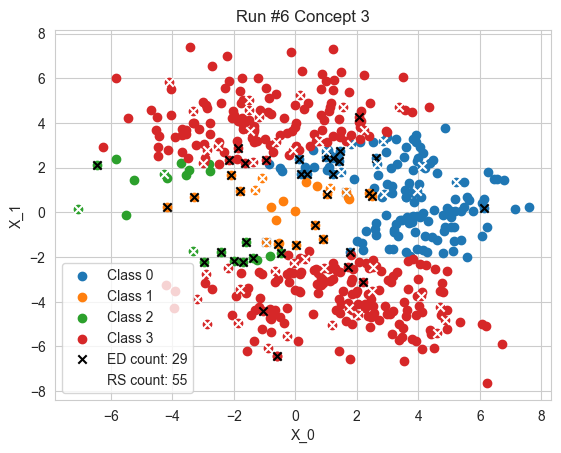

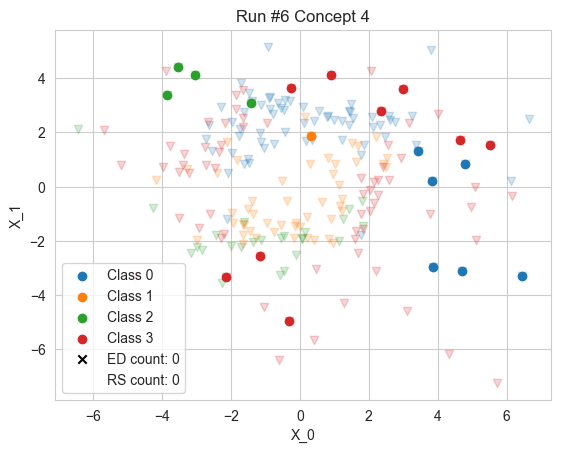

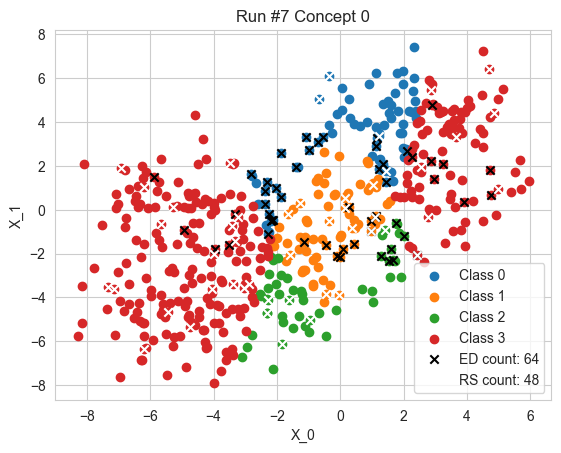

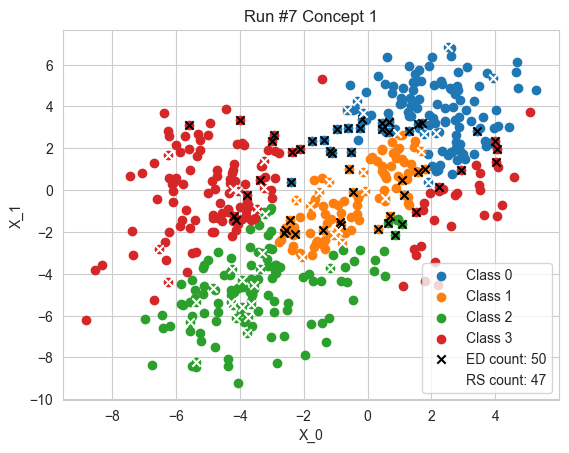

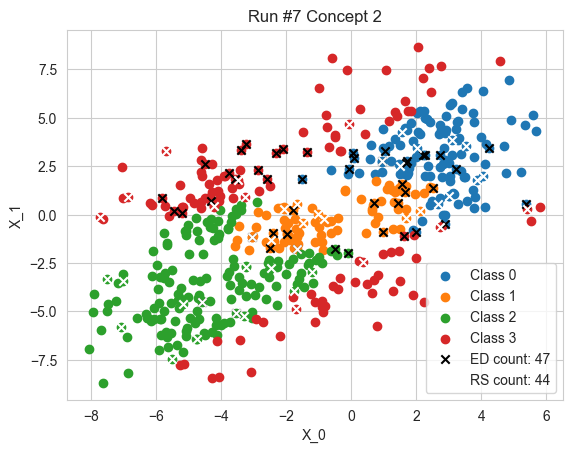

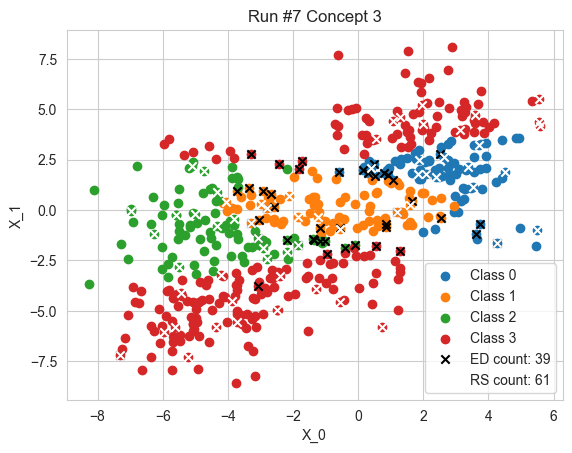

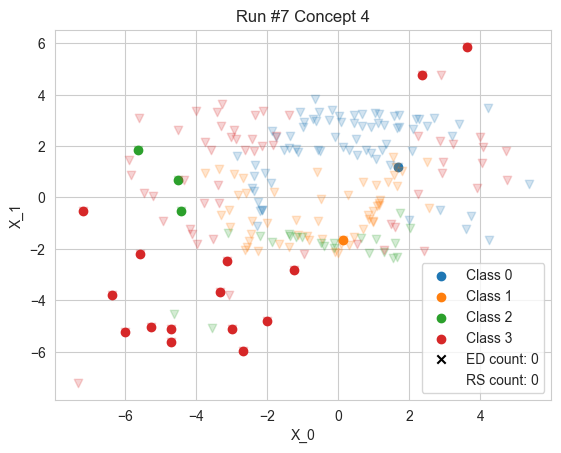

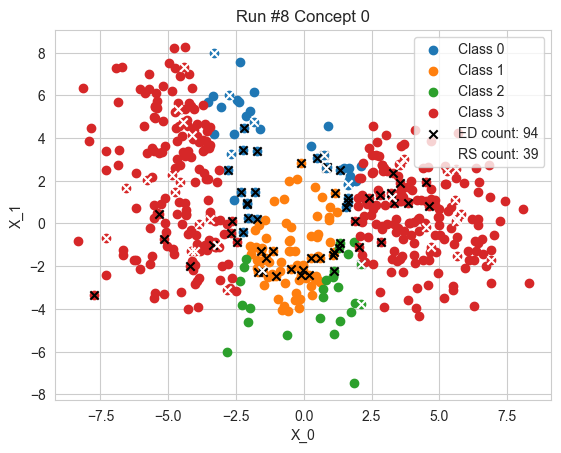

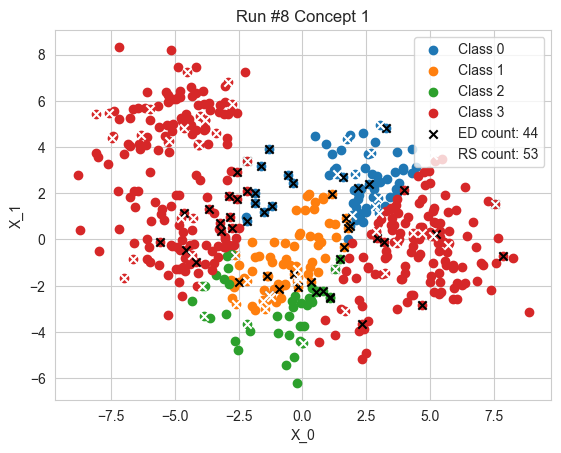

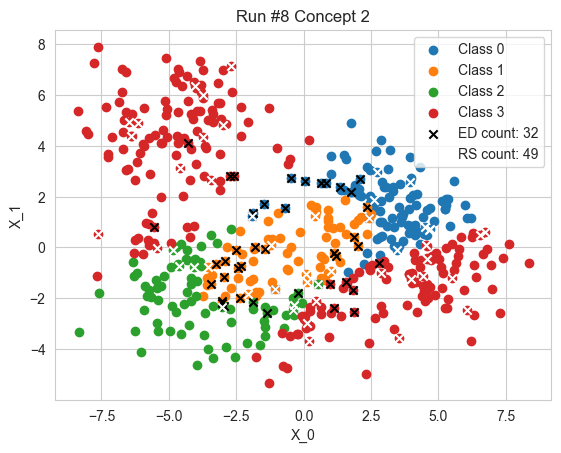

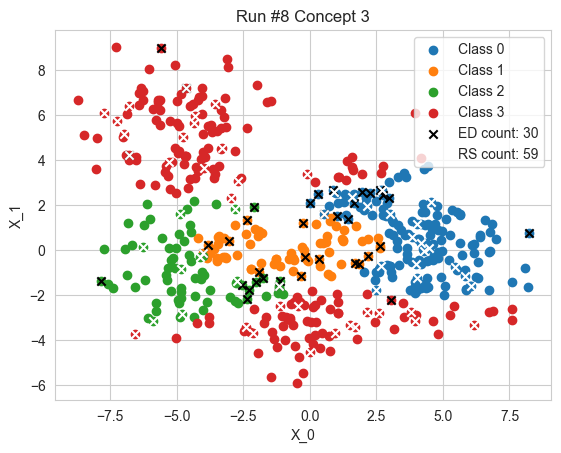

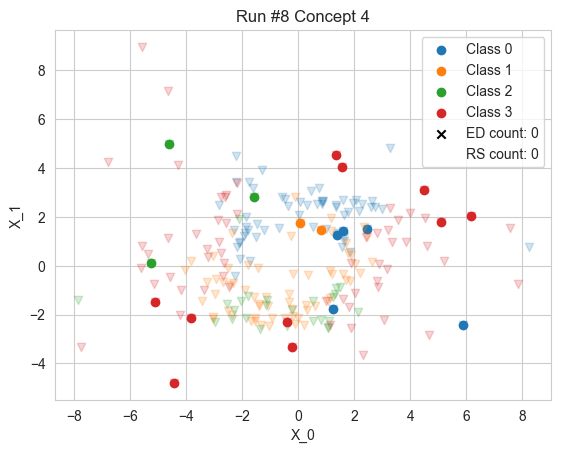

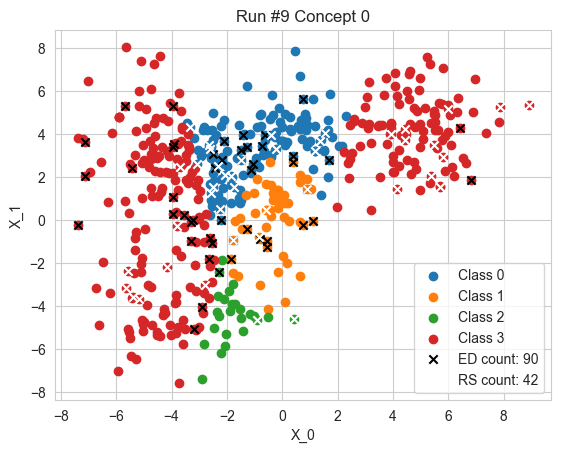

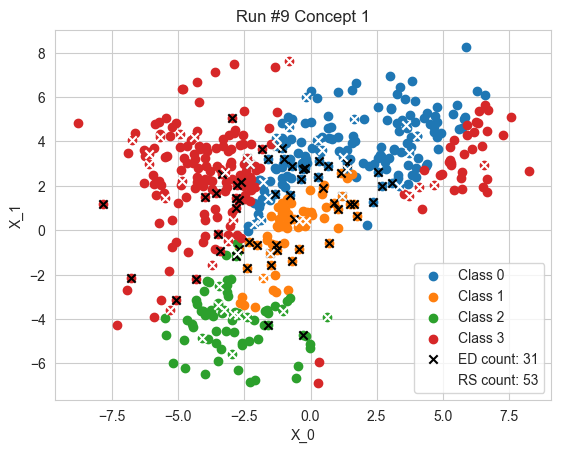

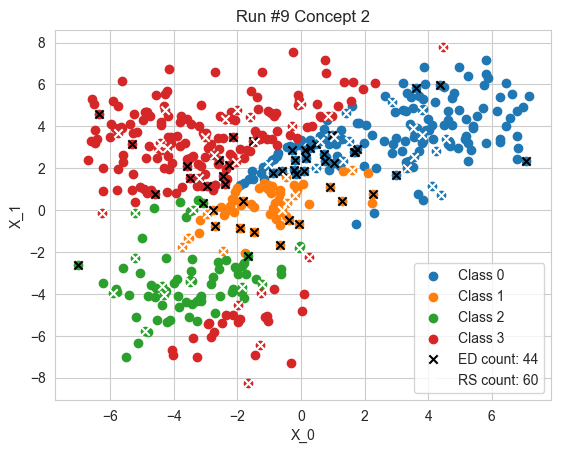

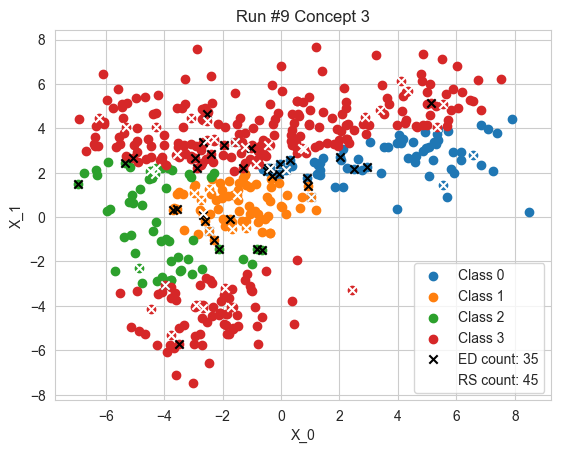

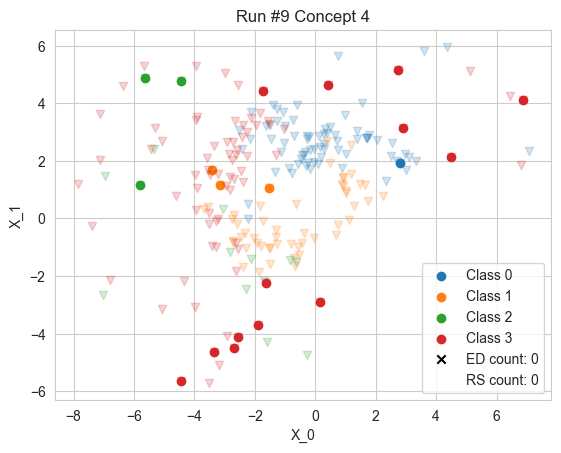

In [19]:
for (run, concept_list) in concept_list_dict.items():
    for index, concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')
        
        selected_samples_ed = pd.merge(concept, ed_selected_samples[run])
        selected_samples_es = pd.merge(concept, es_selected_samples[run])
        selected_samples_rs = pd.merge(concept, rs_selected_samples[run])

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                       label='Class ' + str(int(label)), color=color_list[int(label)])

            if index == len(concept_list) - 1:
                class_samples = ed_selected_samples[run].loc[ed_selected_samples[run]['y_0'] == label]
                selected_samples = pd.concat([group, class_samples], axis=0)
                ax.scatter(selected_samples['X_0'], selected_samples['X_1'], color=color_list[int(label)], alpha=0.2,
                           marker='v')

        plt.scatter(selected_samples_ed['X_0'], selected_samples_ed['X_1'], c='black', marker='x',
                    label='ED count: ' + str(selected_samples_es.value_counts().count()))
        plt.scatter(selected_samples_rs['X_0'], selected_samples_rs['X_1'], c='white', marker='x',
                    label='RS count: ' + str(selected_samples_rs.value_counts().count()))
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()